# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [9]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [10]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [11]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [54]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 2e-9, 3e-9]
regularization_strengths = [3e6, 4e6, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, lr, reg,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = train_acc,val_acc
        if(best_val < val_acc):
            best_val = val_acc
            best_svm = svm

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 2203.442214
iteration 100 / 1500: loss 1212.257459
iteration 200 / 1500: loss 668.761157
iteration 300 / 1500: loss 370.755411
iteration 400 / 1500: loss 207.358394
iteration 500 / 1500: loss 117.766058
iteration 600 / 1500: loss 68.635597
iteration 700 / 1500: loss 41.701083
iteration 800 / 1500: loss 26.929829
iteration 900 / 1500: loss 18.831687
iteration 1000 / 1500: loss 14.390358
iteration 1100 / 1500: loss 11.955594
iteration 1200 / 1500: loss 10.620501
iteration 1300 / 1500: loss 9.888509
iteration 1400 / 1500: loss 9.487398
iteration 0 / 1500: loss 3120.753746
iteration 100 / 1500: loss 1404.965993
iteration 200 / 1500: loss 635.241348
iteration 300 / 1500: loss 289.935454
iteration 400 / 1500: loss 135.032537
iteration 500 / 1500: loss 65.540018
iteration 600 / 1500: loss 34.363791
iteration 700 / 1500: loss 20.378658
iteration 800 / 1500: loss 14.104569
iteration 900 / 1500: loss 11.289216
iteration 1000 / 1500: loss 10.027416
iteration 1100 / 1500: 

In [55]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


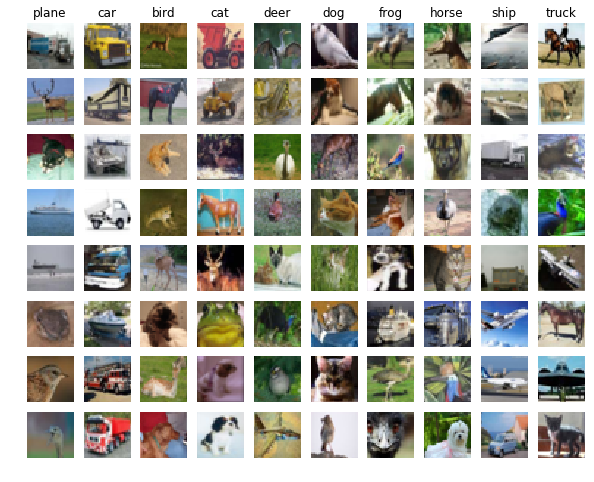

In [56]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [57]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 153)
(49000, 152)


In [52]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None 
best_val = -1 



lr= 3e-1
reg = 1e-1
hpdelay = 1.3
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.9,
            reg=reg, verbose=True)
y_train_pred = net.predict(X_train_feats)
train_acc = np.mean(y_train == y_train_pred)

lrmax = lr*hpdelay
lrmin = lr/hpdelay
regmax = reg*hpdelay
regmin = reg/hpdelay
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lrmax, learning_rate_decay=0.9,
            reg=reg, verbose=True)
y_train_pred = net.predict(X_train_feats)
accup = np.mean(y_train == y_train_pred)
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lrmin, learning_rate_decay=0.9,
            reg=reg, verbose=True)
y_train_pred = net.predict(X_train_feats)
accdown = np.mean(y_train == y_train_pred)
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.9,
            reg=regmin, verbose=True)
y_train_pred = net.predict(X_train_feats)
accleft = np.mean(y_train == y_train_pred)
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.9,
            reg=regmax, verbose=True)
y_train_pred = net.predict(X_train_feats)
accright = np.mean(y_train == y_train_pred)

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_net = net
flag = True
while flag:
    print(train_acc)
    flag = False
    if accleft > max(train_acc,accright):
        accright = train_acc
        train_acc = accleft
        regmax = reg
        reg = regmin
        regmin/=hpdelay
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.9,
            reg=regmin, verbose=True)
        y_train_pred = net.predict(X_train_feats)
        accleft = np.mean(y_train == y_train_pred)
        flag = True
    elif accright > max(train_acc,accleft):
        accleft = train_acc
        train_acc = accright
        regmin = reg
        reg = regmax
        regmax*=hpdelay
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.9,
            reg=regmax, verbose=True)
        y_train_pred = net.predict(X_train_feats)
        accright = np.mean(y_train == y_train_pred)
        flag = True
    if accup > max(train_acc,accdown):
        accdown = train_acc
        train_acc = accup
        lrmin = lr
        lr = lrmax
        lrmax*=hpdelay
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lrmax, learning_rate_decay=0.9,
            reg=reg, verbose=True)
        y_train_pred = net.predict(X_train_feats)
        accup = np.mean(y_train == y_train_pred)
        flag = True
    elif accdown > max(train_acc,accup):
        accup = train_acc
        train_acc = accdown
        lrmax = lr
        lr = lrmin
        lrmin/=hpdelay
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=lrmin, learning_rate_decay=0.9,
            reg=reg, verbose=True)
        y_train_pred = net.predict(X_train_feats)
        accdown = np.mean(y_train == y_train_pred)
        flag = True
best_net = TwoLayerNet(input_dim, hidden_dim, num_classes)
stats = best_net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=1500, batch_size=200,
        learning_rate=lr, learning_rate_decay=0.9,
        reg=reg, verbose=True)



pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 1500: loss 2.302667
iteration 100 / 1500: loss 2.300956
iteration 200 / 1500: loss 2.220261
iteration 300 / 1500: loss 2.213459
iteration 400 / 1500: loss 2.173067
iteration 500 / 1500: loss 2.121884
iteration 600 / 1500: loss 2.138113
iteration 700 / 1500: loss 2.105513
iteration 800 / 1500: loss 2.183050
iteration 900 / 1500: loss 2.133897
iteration 1000 / 1500: loss 2.151271
iteration 1100 / 1500: loss 2.120584
iteration 1200 / 1500: loss 2.146200
iteration 1300 / 1500: loss 2.168628
iteration 1400 / 1500: loss 2.129801
iteration 0 / 1500: loss 2.302667
iteration 100 / 1500: loss 2.284723
iteration 200 / 1500: loss 2.204575
iteration 300 / 1500: loss 2.127343
iteration 400 / 1500: loss 2.126556
iteration 500 / 1500: loss 2.144700
iteration 600 / 1500: loss 2.124197
iteration 700 / 1500: loss 2.190446
iteration 800 / 1500: loss 2.189896
iteration 900 / 1500: loss 2.152667
iteration 1000 / 1500: loss 2.145563
iteration 1100 / 1500: loss 2.129614
iteration 1200 / 1500: lo

iteration 1200 / 1500: loss 1.524378
iteration 1300 / 1500: loss 1.463450
iteration 1400 / 1500: loss 1.448618
0.5384285714285715
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 1.881876
iteration 200 / 1500: loss 1.582956
iteration 300 / 1500: loss 1.445265
iteration 400 / 1500: loss 1.460588
iteration 500 / 1500: loss 1.450719
iteration 600 / 1500: loss 1.402364
iteration 700 / 1500: loss 1.380059
iteration 800 / 1500: loss 1.508793
iteration 900 / 1500: loss 1.397919
iteration 1000 / 1500: loss 1.431400
iteration 1100 / 1500: loss 1.477746
iteration 1200 / 1500: loss 1.616102
iteration 1300 / 1500: loss 1.470581
iteration 1400 / 1500: loss 1.395200
0.550469387755102
iteration 0 / 1500: loss 2.302588
iteration 100 / 1500: loss 1.904925
iteration 200 / 1500: loss 1.581667
iteration 300 / 1500: loss 1.404400
iteration 400 / 1500: loss 1.396321
iteration 500 / 1500: loss 1.520965
iteration 600 / 1500: loss 1.370359
iteration 700 / 1500: loss 1.346161
iteration 800 / 1500: l

In [53]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.563
